# CNN data analysis - Analysis of image data

## Python imports

In [2]:
import csv
import numpy as np
import os.path
import pandas as pd
import matplotlib.pyplot as pyplt
import cv2

## Parameters

## Collect data

In [19]:
# ========== Quality metric helpers ==========
def compute_sharpness(img_gray):
    """Sharpness via variance of Laplacian."""
    return cv2.Laplacian(img_gray, cv2.CV_64F).var()

def compute_noise(img_gray):
    """Estimate noise using local variance in flat regions."""
    h, w = img_gray.shape
    M = cv2.meanStdDev(img_gray)
    return float(M[1]**2)  # variance as noise estimate

def compute_exposure(img_gray):
    """Exposure balance: ratio of well-exposed pixels."""
    hist = cv2.calcHist([img_gray], [0], None, [256], [0,256])
    hist_norm = hist.ravel() / hist.sum()
    under = hist_norm[:30].sum()
    over  = hist_norm[225:].sum()
    well_exposed = 1.0 - (under + over)
    return well_exposed


# ========== Main processing ==========
def analyze(df):
    results = []
    print('Analysing', len(df), 'images')
    for _,row in df.iterrows():
        img = cv2.imread(row['image'])
        if img is None:
            continue
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Metrics
        sharpness = compute_sharpness(gray)              # higher = sharper
        noise = compute_noise(gray)                      # lower = cleaner
        exposure = compute_exposure(gray)                # closer to 1 = good

        results.append({
            "image": row['image'],
            "source": row['source'],
            "sharpness": sharpness,
            "noise": noise,
            "exposure": exposure,
        })
    return pd.DataFrame(results)


all_data = {
    'TS':  analyze(pd.read_csv('datasets/vision/TS.tsv', sep='\t')),
    'PW':  analyze(pd.read_csv('datasets/vision/PW.tsv', sep='\t')),
    'RW':  analyze(pd.read_csv('datasets/vision/RW.tsv', sep='\t'))
}


Analysing 941 images


/tmp/ipykernel_8113/3711847095.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(M[1]**2)  # variance as noise estimate


Analysing 374 images


/tmp/ipykernel_8113/3711847095.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(M[1]**2)  # variance as noise estimate


Analysing 539 images


/tmp/ipykernel_8113/3711847095.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(M[1]**2)  # variance as noise estimate


In [21]:
all_data['PTS'] =  all_data['TS'][all_data['TS'].source == 'Pixel']
all_data['RTS'] =  all_data['TS'][all_data['TS'].source == 'Redmi']
all_data['RTS']

,image,source,sharpness,noise,exposure
508,video_data/SS/test_Xiaomi_0000_0000.jpeg,Redmi,0.574754,0.831907,0.000120
509,video_data/SS/test_Xiaomi_0001_0031.jpeg,Redmi,68.659781,1683.264058,0.958760
510,video_data/SS/test_Xiaomi_0002_0061.jpeg,Redmi,30.579817,1594.322699,0.964941
511,video_data/SS/test_Xiaomi_0003_0091.jpeg,Redmi,36.051817,2249.073778,0.988519
512,video_data/SS/test_Xiaomi_0011_0331.jpeg,Redmi,31.661464,3191.923108,0.940578
...,...,...,...,...,...
936,video_data/AT_I2/test_Xiaomi_0085_2551.jpeg,Redmi,4.294142,1907.573891,0.959629
937,video_data/AT_I2/test_Xiaomi_0090_2701.jpeg,Redmi,27.363937,2178.031821,0.976636
938,video_data/AT_I2/test_Xiaomi_0098_2941.jpeg,Redmi,4.305897,1576.569341,0.968367
939,video_data/AT_I2/test_Xiaomi_0102_2971.jpeg,Redmi,14.721719,1152.043551,0.978135


## Draw plots

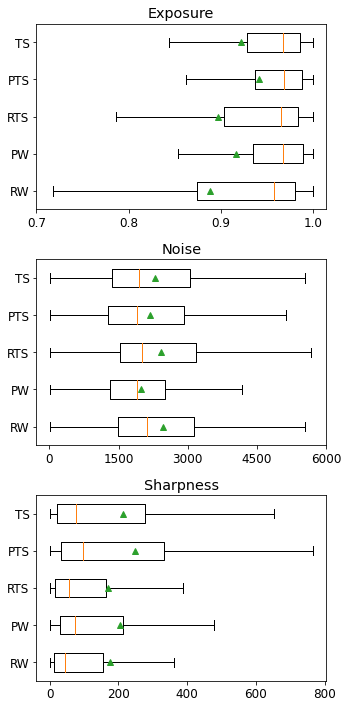

In [33]:
font = {'family' : 'normal',
        'size'   : 12}
pyplt.rc('font', **font)
pyplt.rcParams["figure.figsize"] = (5,10)

f, p = pyplt.subplots(3,1) #sharey=True)

p[0].boxplot([all_data[x]['exposure'] for x in ['TS', 'PTS', 'RTS','PW','RW']],
             vert=False, 
             showfliers=False,
             showmeans=True,
             labels=['TS', 'PTS', 'RTS','PW','RW'])
p[0].set_title('Exposure')
p[0].invert_yaxis()
p[0].set_xticks([0.7, 0.8, 0.9, 1.0])

p[1].boxplot([all_data[x]['noise'] for x in ['TS', 'PTS', 'RTS','PW','RW']],
             vert=False, 
             showfliers=False,
             showmeans=True,
             labels=['TS', 'PTS', 'RTS','PW','RW'])
p[1].set_title('Noise')
p[1].invert_yaxis()
p[1].set_xticks([0, 1500, 3000, 4500, 6000])

p[2].boxplot([all_data[x]['sharpness'] for x in ['TS', 'PTS', 'RTS','PW','RW']],
             vert=False, 
             showfliers=False,
             showmeans=True,
             labels=['TS', 'PTS', 'RTS','PW','RW'])
p[2].set_title('Sharpness')
p[2].invert_yaxis()
f.tight_layout()
f.get_figure().savefig("image_analysis_boxplots.pdf")